In [314]:
#############
# SREX masks
#############


import numpy as np
import netCDF4 as net
import dimarray as da 
import sys
import itertools
import glob
import datetime
import pickle
import os
import pandas as pd
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pylab as plt 
from six import string_types
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 8,6

sys.path.append('/Users/peterpfleiderer/Documents/0p5_observed/')

try:
    import pdf_processing as pdf; reload(pdf)
except ImportError:
    raise ImportError(
        "cannot find PDF_Processing code")
    

from shapely.geometry import Polygon, MultiPolygon


# Variable
varin='TX90p'
read_in_data=da.read_nc('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/HadEx2/H2_'+varin+'_1901-2010_RegularGrid_global_3.75x2.5deg_LSmask.nc')['Ann']

# Set working dir

#Set annual time axis for input data 
timeaxis=np.arange(1901,2011)

# Set regular integer time axis, dimarray default always adds month and day. Time range 1951-2010
input_data=da.DimArray(read_in_data[:20100101,:,:], axes=[timeaxis, read_in_data.lat, read_in_data.lon],dims=['year', 'lat', 'lon'] )

0p5 reference period for  Nasa 2010 :  [1960, 1979]
No of non-NAN grid cells in Mask over Ref period:  1415
No of non-NAN grid cells in Mask over Ref period and target period  [1991, 2010]  :  1216


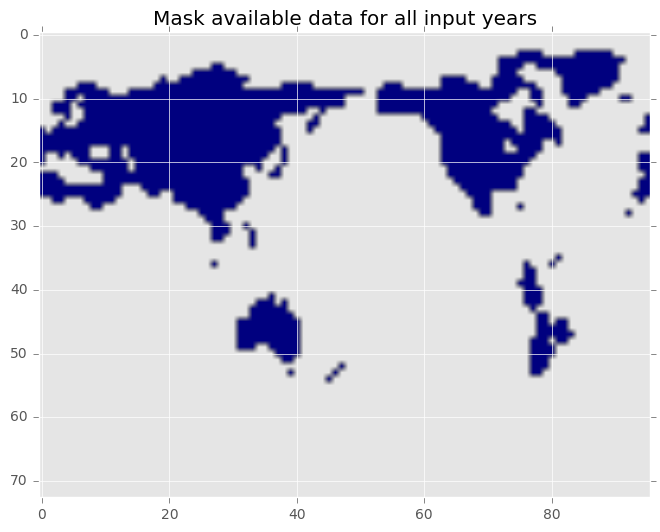

In [315]:
###########
# Settings
###########

# Set GMT dataset
gmtds='Nasa'

# Set Final year in Extreme Event database with sufficient coverage
# 2013 for GHCND, 2010 for HadEx2
ref_year=2010

dgmtp=np.load('/Users/peterpfleiderer/Box Sync/0p5_observational_record/scripts/GMT_time_series/GMT_0p5_diff_intervals.dat')

# print dgmtp#,ref_year,gmtds
ref_period=dgmtp[ref_year][gmtds][::-1]

print '0p5 reference period for ',gmtds,ref_year,': ',ref_period
target_periods=[[ref_year-19,ref_year]]
period_names=['Recent','ref']


# Mask for data availability
varpdf=pdf.PDF_Processing(varin,'/Users/peterpfleiderer/Documents/0p5_observed/')
varpdf.mask_for_ref_period_data_coverage(input_data,ref_period,check_ref_period_only=False,target_periods=target_periods)

# Plot data mask
plt.figure()
plt.imshow(varpdf._masks['global'][::-1,:])
plt.title('Mask available data for all input years')

plt.show()

In [316]:
srex_polygons = np.load('srex_dict.dat')
varpdf.derive_regional_masking(input_data,shift_lon=-180.0,regions_polygons=srex_polygons)

Read grid information and create polygons according to the projection.


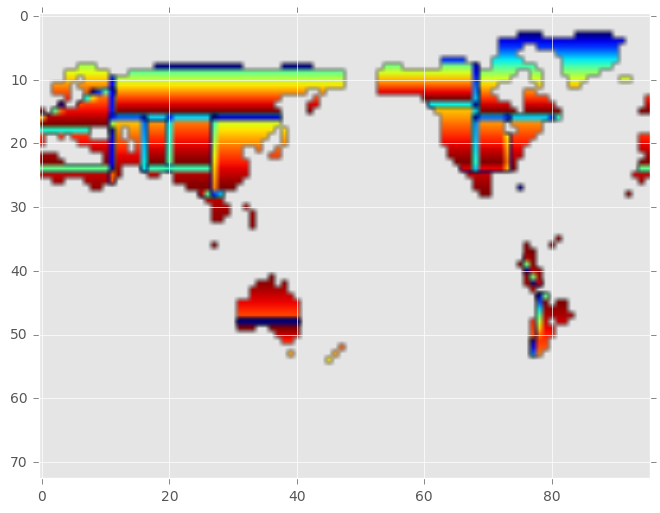

In [318]:
for region in varpdf._masks.keys():
    if region!='global':
        plt.imshow(varpdf._masks[region][::-1,:])
plt.show()

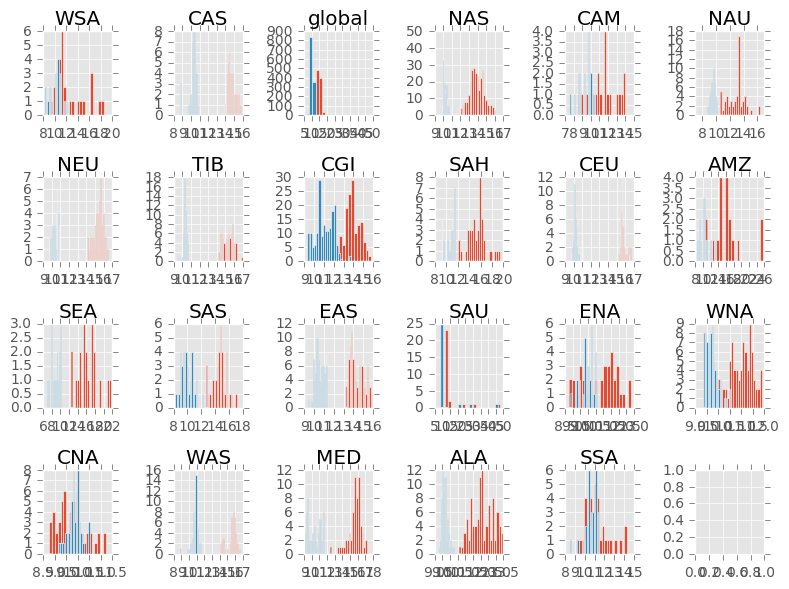

In [319]:
sys.path.append('/Users/peterpfleiderer/Documents/0p5_observed/')

try:
    import pdf_processing as pdf; reload(pdf)
except ImportError:
    raise ImportError(
        "cannot find PDF_Processing code")

###########
# Derive time slices
###########
varpdf.derive_time_slices(input_data,ref_period,target_periods,period_names)
varpdf.derive_distributions()


#plt.figure()
#for key in varpdf._periods:
#    plt.hist(varpdf._distributions['global'][key],bins=50)
#plt.title('Distribution over grid cells, ref vs target period, '+ varin)
#plt.show()

plt.clf()
f,a = plt.subplots(4,6)
a = a.ravel()
for idx,ax in enumerate(a):
    if idx<23:
        region=varpdf._distributions.keys()[idx]    
        for key in varpdf._periods:
            dat=varpdf._distributions[region][key]
            ax.hist(varpdf._distributions[region][key],bins=20)
        ax.set_title(region)
f.tight_layout()
plt.show()




In [326]:
###########
# DERIVE PDF/CDFs
###########

for region in varpdf._masks.keys():
    # Define cutting interval for the kernel estimate. Default is 0:100 for percentile based indicators
    cutinterval=[varpdf._distributions[region]['ref'].min()*0.9,varpdf._distributions[region]['Recent'].max()*1.2]
    # Set bandwith for kernel estimate
    bw=(cutinterval[1]-cutinterval[0])/40
    # Derive Kernel estimate
    varpdf.kernel_in_R(cutinterval,bw,region=region)




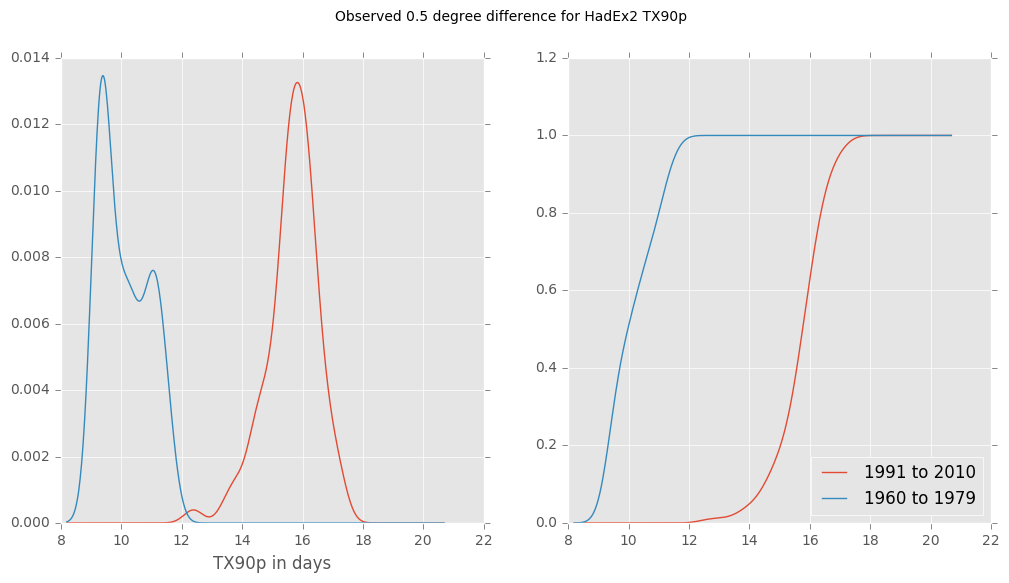

In [328]:
# Plot
f,pl=plt.subplots(ncols=2,figsize=(12,6))

# Legend Dict
ldict={
    'ref':str(ref_period[0])+' to '+str(ref_period[1]),
    'Recent':str(target_periods[0][0])+' to '+str(target_periods[0][1])
}

for key in varpdf._periods:
    pdf_distro=varpdf._distributions['MED'][key+'_pdf']
    pl[0].plot(pdf_distro[:,0],pdf_distro[:,1],label=ldict[key])    
    cdf_distro=varpdf._distributions['MED'][key+'_cdf']
    pl[1].plot(cdf_distro[:,0],cdf_distro[:,1],label=ldict[key])

pl[1].legend(loc='lower right')
pl[0].set_xlabel(varin+' in days')
f.suptitle('Observed 0.5 degree difference for HadEx2 '+varin)
plt.savefig('plots/Observed_0p5_degree_difference_for_HadEx2_'+varin+'.pdf')
plt.show()

#print varpdf._distributions['global']['ref_pdf']